In [56]:
# Load libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import cv
from sklearn.preprocessing import OrdinalEncoder
import scipy.stats as stats

In [18]:
# STAGE 1 - CLEANING
# info on the dataset which needs a proper cleaning
df=pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [19]:
# deleting Id columns as non-informative for modelling
df=df.drop('Id',axis=1)

In [20]:
# inspecting the columns with nans
round(df.isna().sum()/len(df)*100,2)

MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
Street            0.00
Alley            93.77
LotShape          0.00
LandContour       0.00
Utilities         0.00
LotConfig         0.00
LandSlope         0.00
Neighborhood      0.00
Condition1        0.00
Condition2        0.00
BldgType          0.00
HouseStyle        0.00
OverallQual       0.00
OverallCond       0.00
YearBuilt         0.00
YearRemodAdd      0.00
RoofStyle         0.00
RoofMatl          0.00
Exterior1st       0.00
Exterior2nd       0.00
MasVnrType        0.55
MasVnrArea        0.55
ExterQual         0.00
ExterCond         0.00
Foundation        0.00
BsmtQual          2.53
BsmtCond          2.53
BsmtExposure      2.60
BsmtFinType1      2.53
BsmtFinSF1        0.00
BsmtFinType2      2.60
BsmtFinSF2        0.00
BsmtUnfSF         0.00
TotalBsmtSF       0.00
Heating           0.00
HeatingQC         0.00
CentralAir        0.00
Electrical        0.07
1stFlrSF          0.00
2ndFlrSF   

In [21]:
# I'll start with the categorical cols treatment for nans
all_cols=list(df.columns)
num_cols=list(df._get_numeric_data().columns)
cat_cols=list(set(all_cols)-set(num_cols))
round(df[cat_cols].isna().sum()/len(df[cat_cols])*100,2)

RoofMatl          0.00
BsmtFinType1      2.53
PoolQC           99.52
Fence            80.75
GarageCond        5.55
Utilities         0.00
Condition2        0.00
Functional        0.00
BldgType          0.00
MasVnrType        0.55
HouseStyle        0.00
RoofStyle         0.00
BsmtExposure      2.60
GarageType        5.55
ExterCond         0.00
MSZoning          0.00
ExterQual         0.00
LandContour       0.00
Exterior2nd       0.00
BsmtCond          2.53
Heating           0.00
KitchenQual       0.00
Condition1        0.00
HeatingQC         0.00
BsmtQual          2.53
GarageQual        5.55
Electrical        0.07
Alley            93.77
PavedDrive        0.00
BsmtFinType2      2.60
Foundation        0.00
Neighborhood      0.00
GarageFinish      5.55
FireplaceQu      47.26
LandSlope         0.00
CentralAir        0.00
LotShape          0.00
Exterior1st       0.00
MiscFeature      96.30
SaleType          0.00
SaleCondition     0.00
LotConfig         0.00
Street            0.00
dtype: floa

In [22]:
# replacing nans for the columns with many nans for further inspection
df["PoolQC"].replace(np.nan, "Zut",inplace=True)
df["Alley"].replace(np.nan, "Zut",inplace=True)
df["MiscFeature"].replace(np.nan, "Zut",inplace=True)
df["FireplaceQu"].replace(np.nan, "Zut",inplace=True)
df["Fence"].replace(np.nan, "Zut",inplace=True)

In [23]:
# replacing nans for the columns with a few nans by the most frequent labels
df['GarageQual'] = df['GarageQual'].fillna(df['GarageQual'].value_counts().index[0])
df['GarageCond'] = df['GarageCond'].fillna(df['GarageCond'].value_counts().index[0])
df['BsmtCond'] = df['BsmtCond'].fillna(df['BsmtCond'].value_counts().index[0])
df['GarageType'] = df['GarageType'].fillna(df['GarageType'].value_counts().index[0])
df['BsmtExposure'] = df['BsmtExposure'].fillna(df['BsmtExposure'].value_counts().index[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].value_counts().index[0])
df['BsmtQual'] = df['BsmtQual'].fillna(df['BsmtQual'].value_counts().index[0])
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].value_counts().index[0])
df['GarageFinish'] = df['GarageFinish'].fillna(df['GarageFinish'].value_counts().index[0])
df['BsmtFinType2'] = df['BsmtFinType2'].fillna(df['BsmtFinType2'].value_counts().index[0])
df['BsmtFinType1'] = df['BsmtFinType1'].fillna(df['BsmtFinType1'].value_counts().index[0])

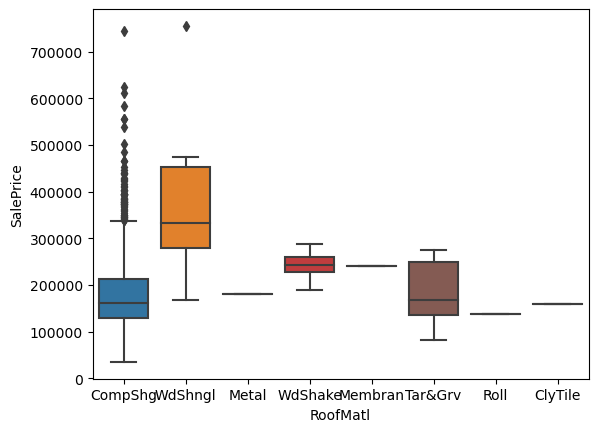

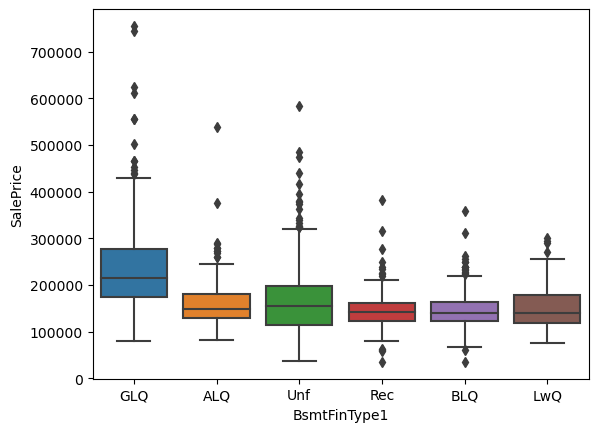

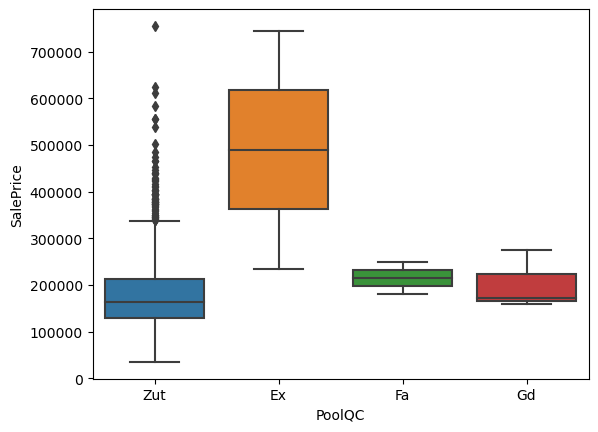

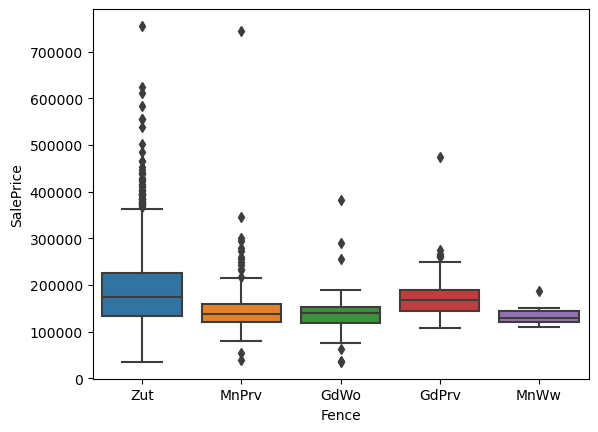

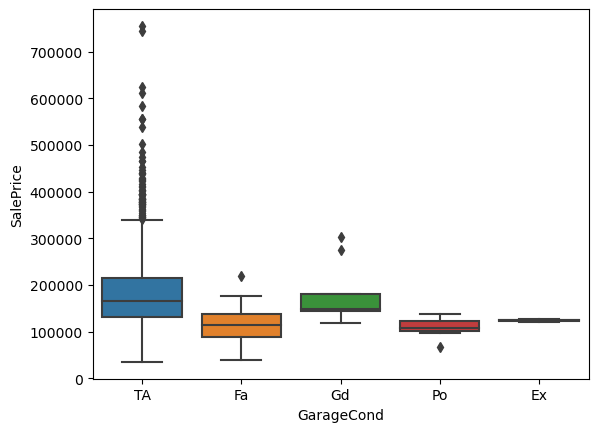

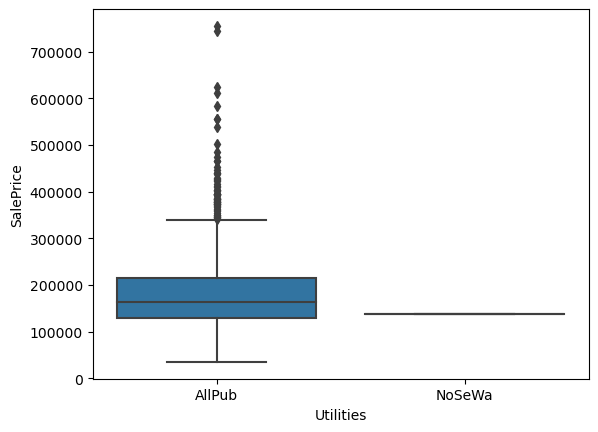

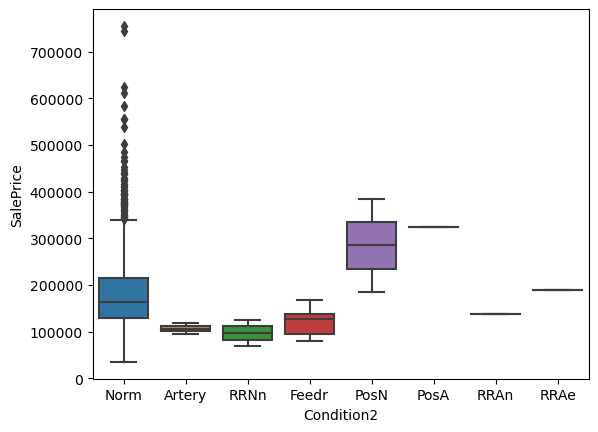

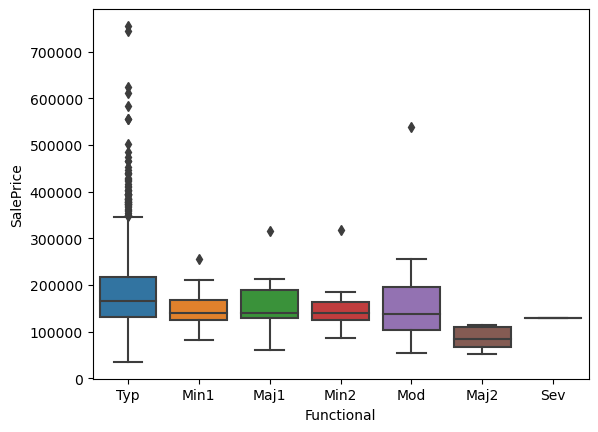

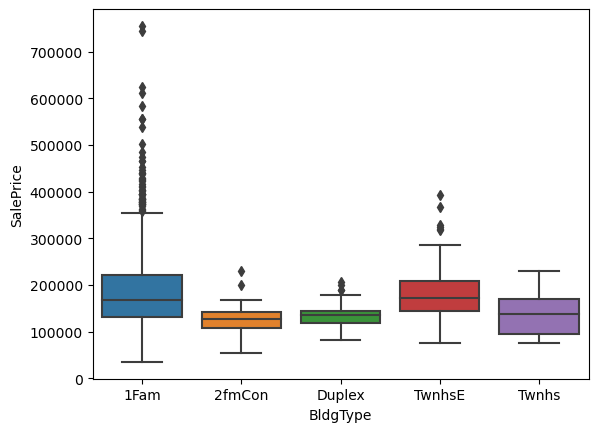

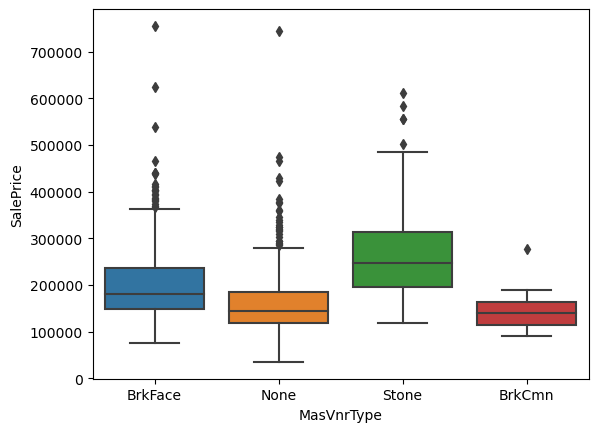

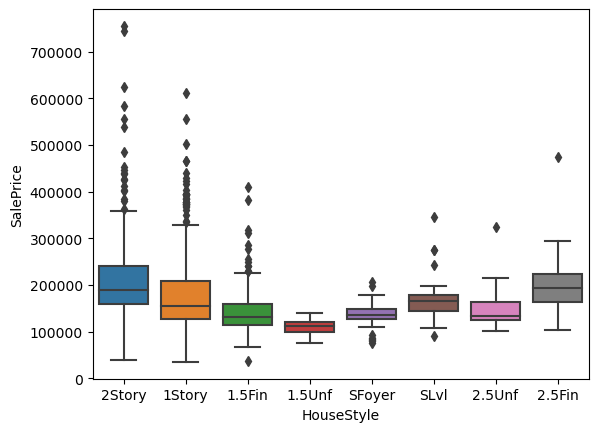

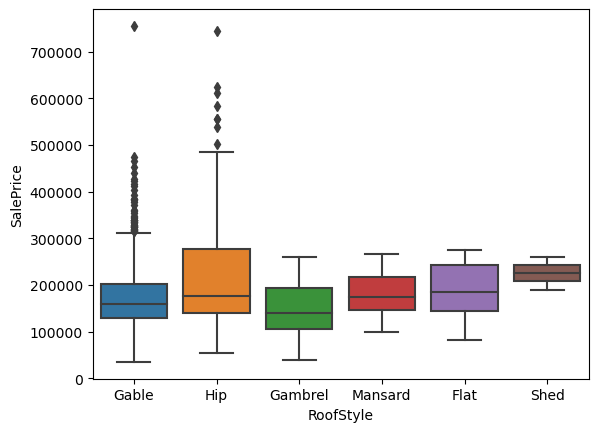

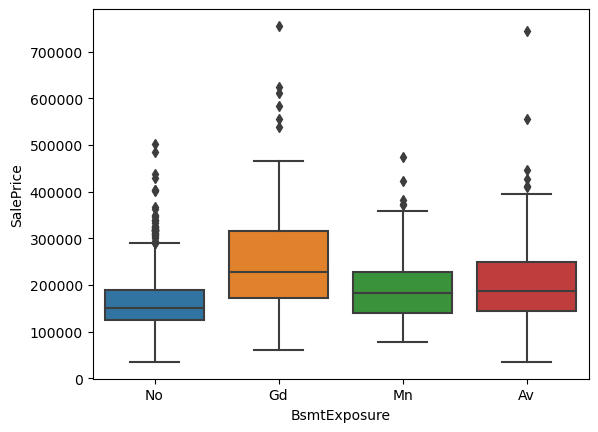

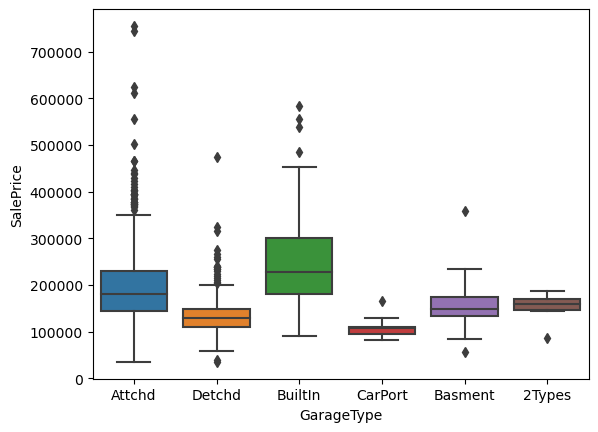

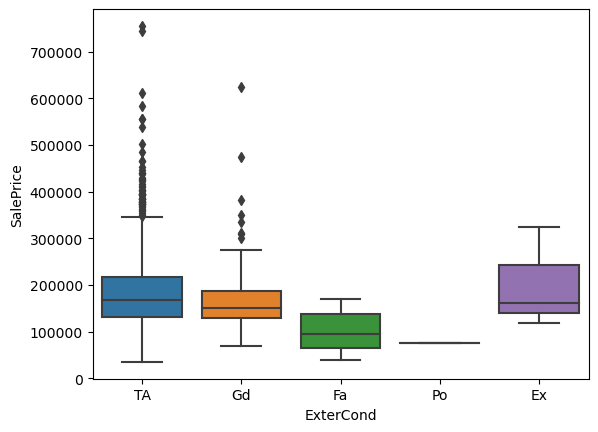

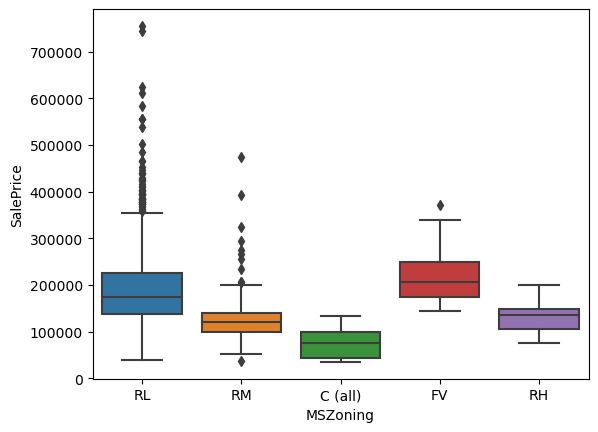

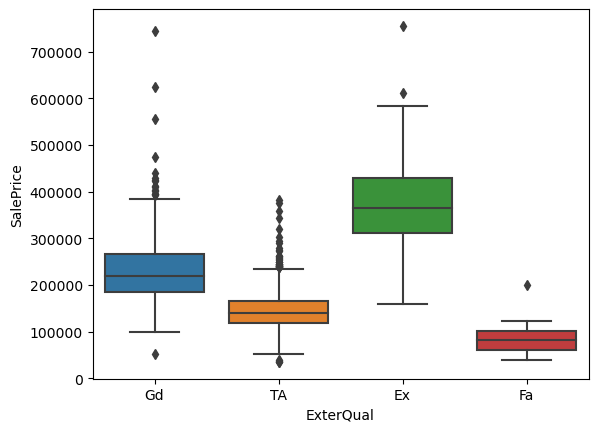

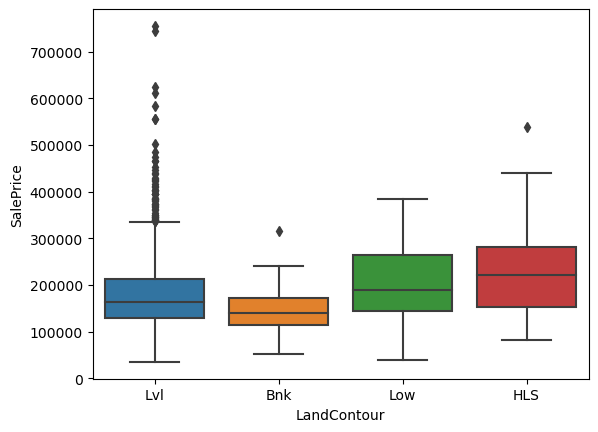

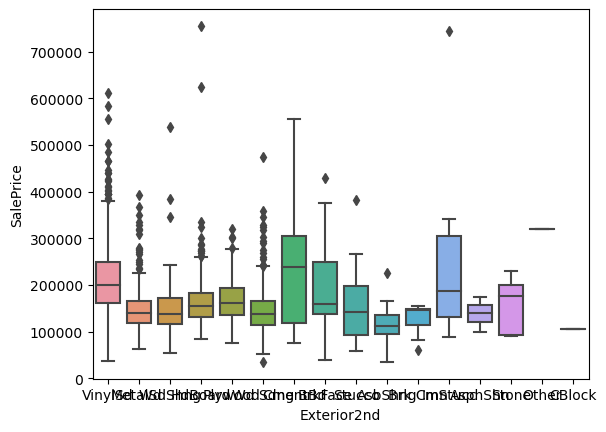

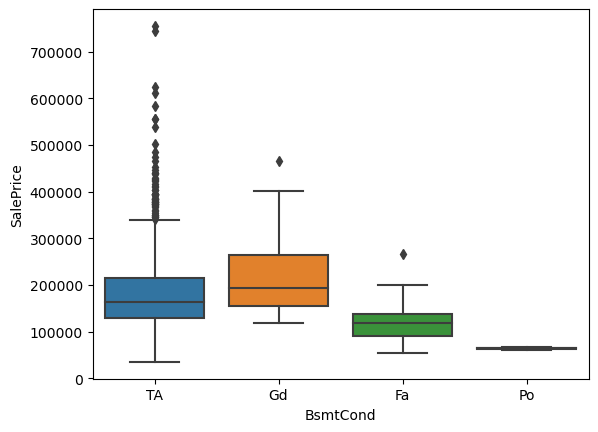

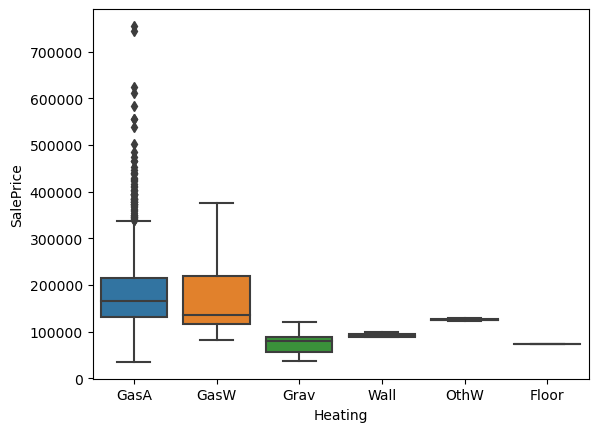

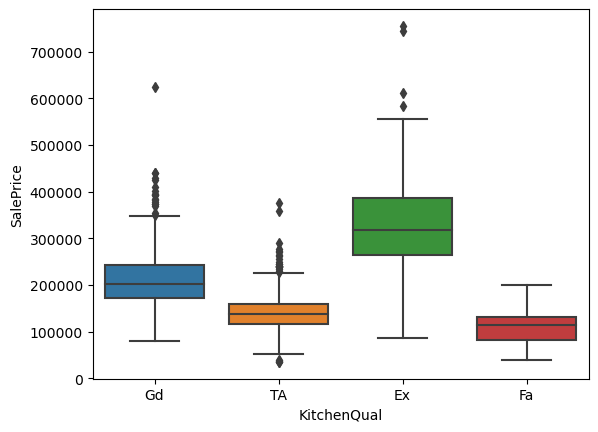

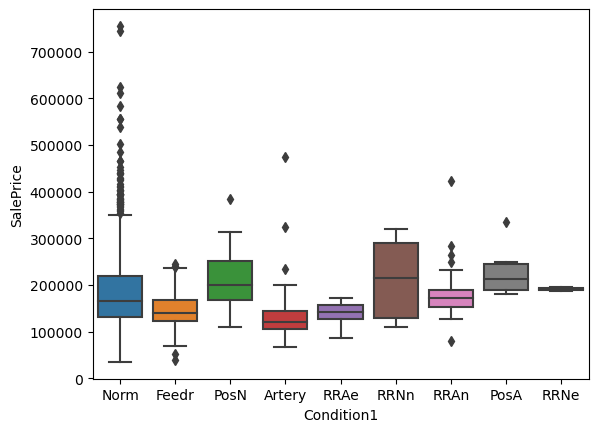

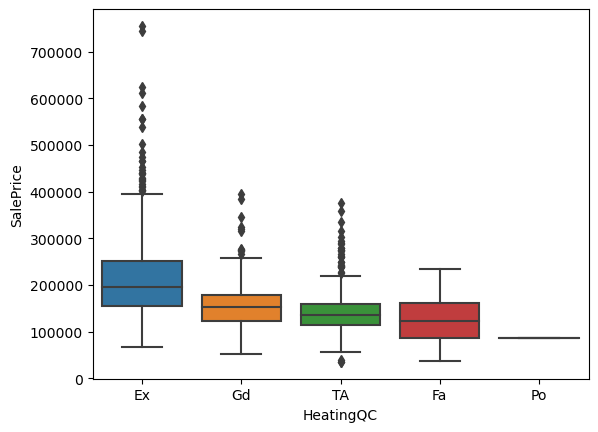

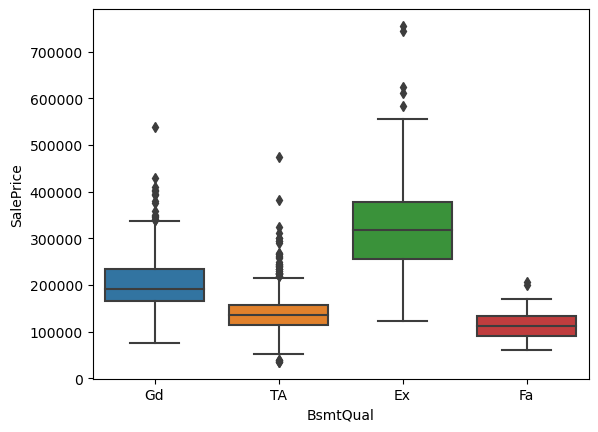

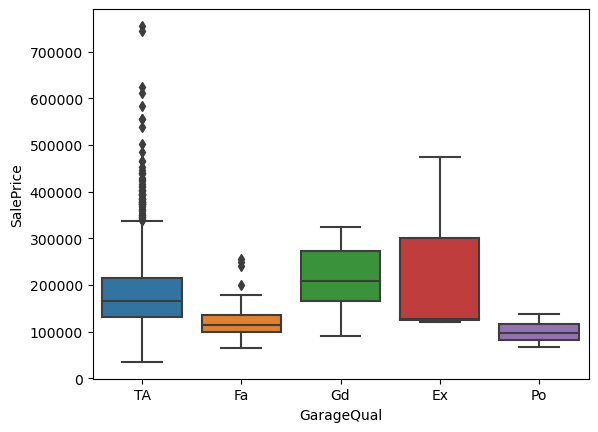

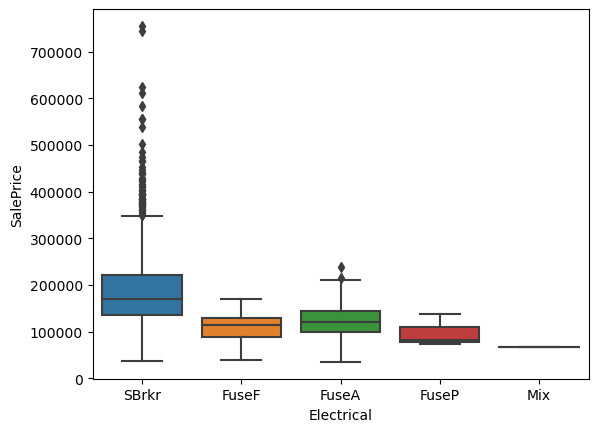

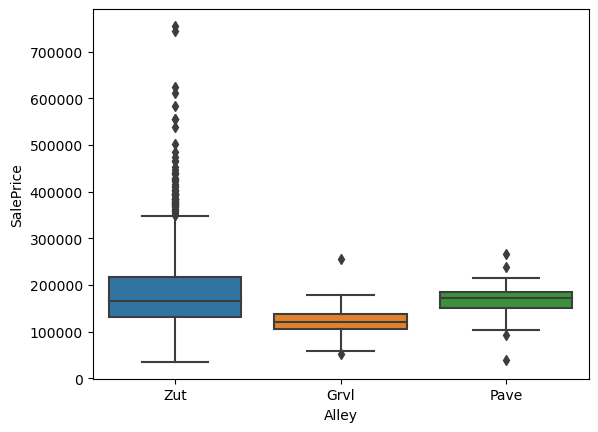

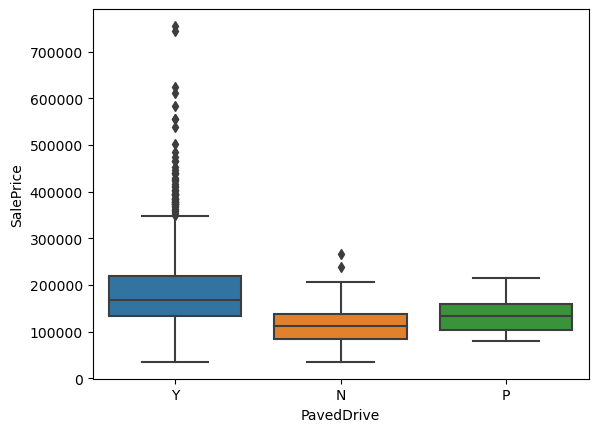

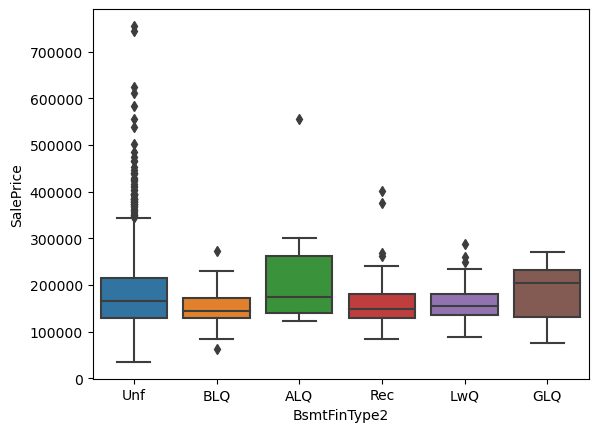

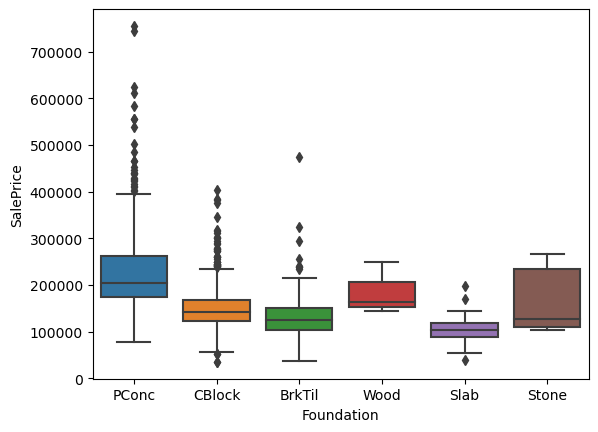

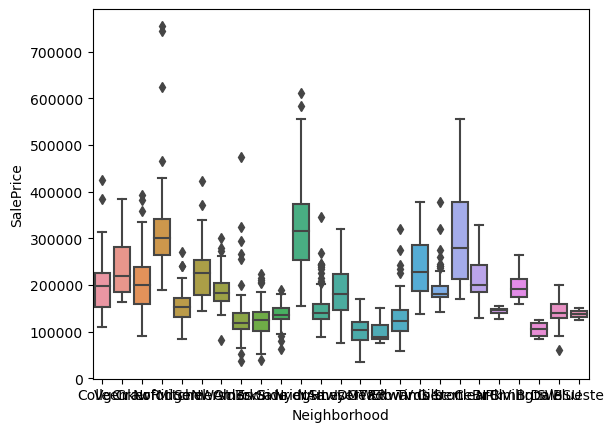

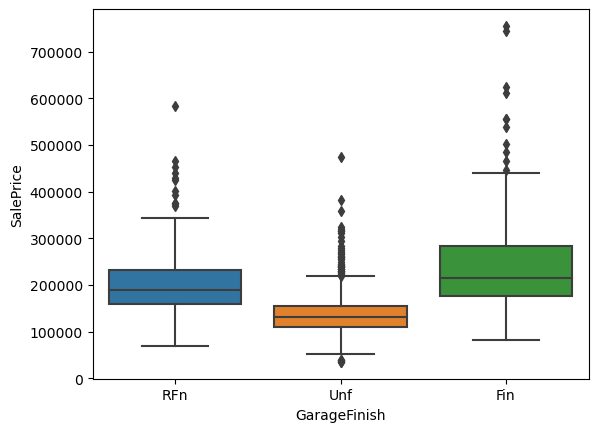

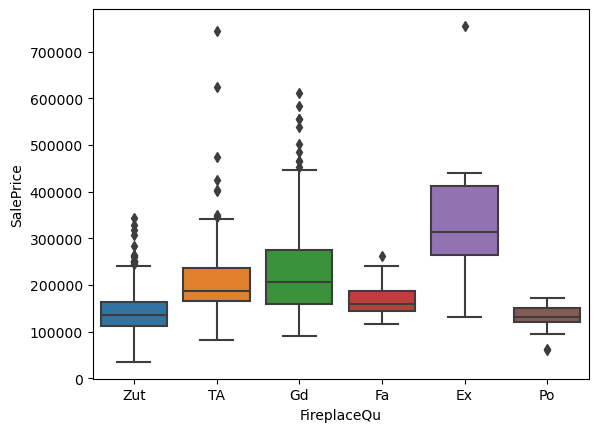

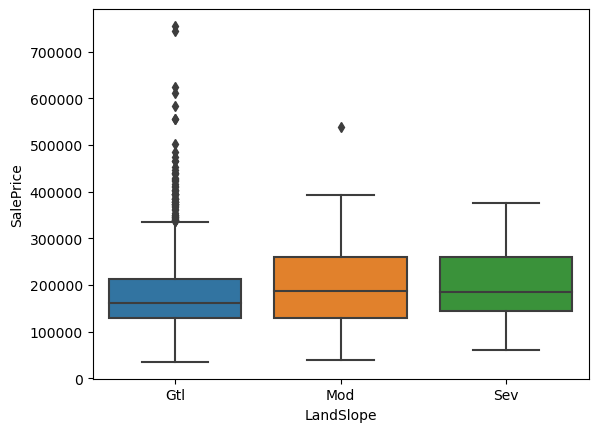

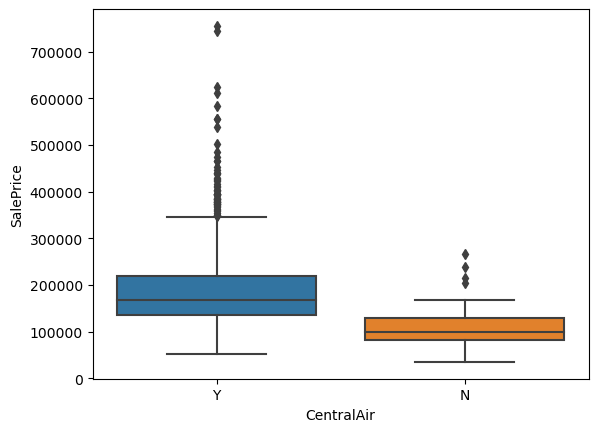

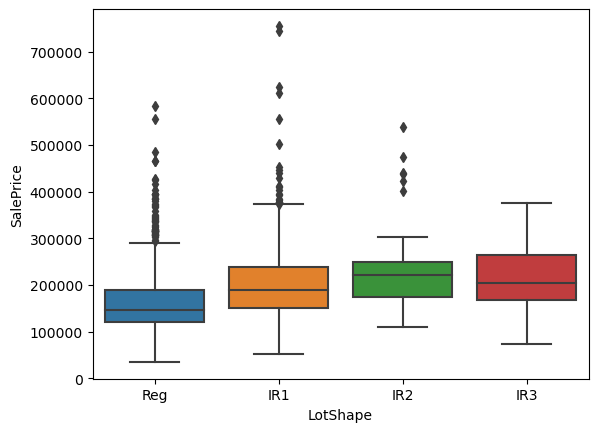

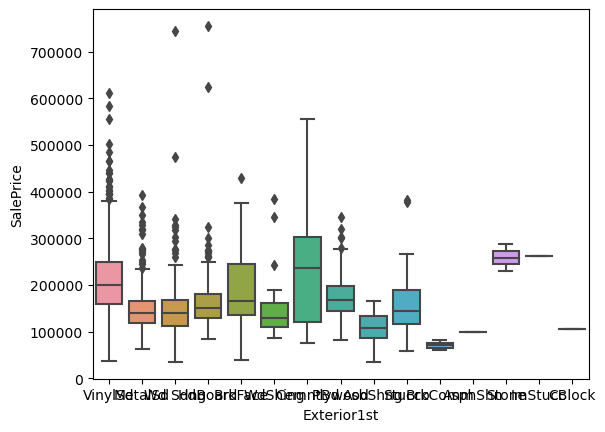

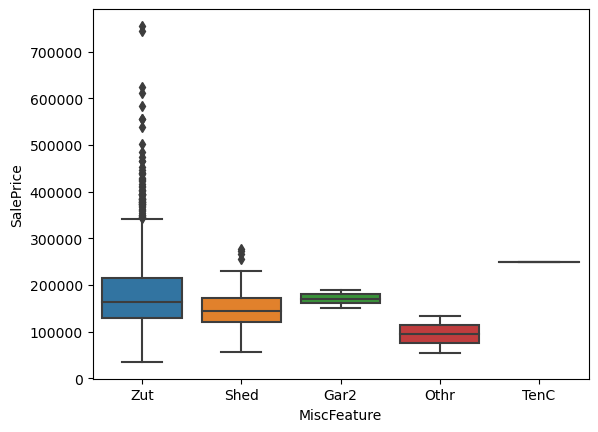

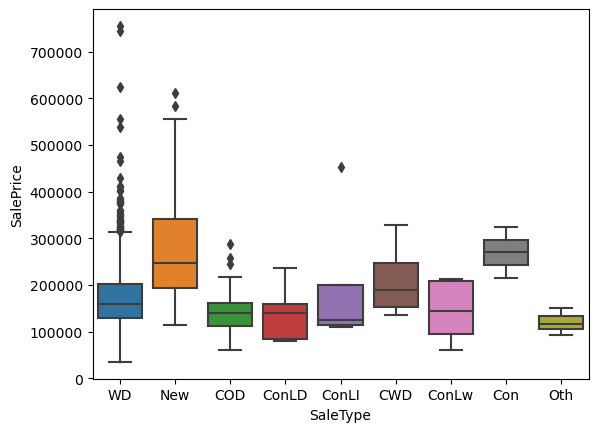

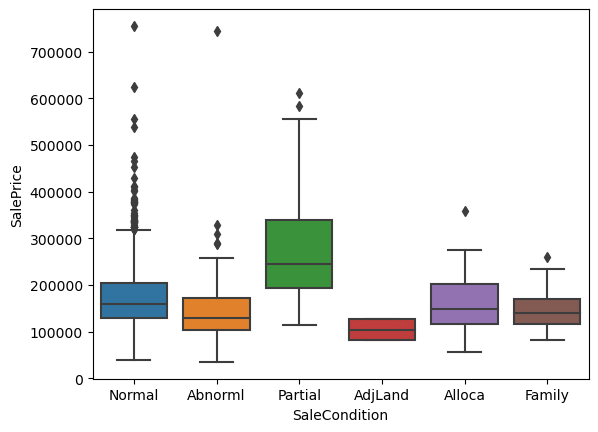

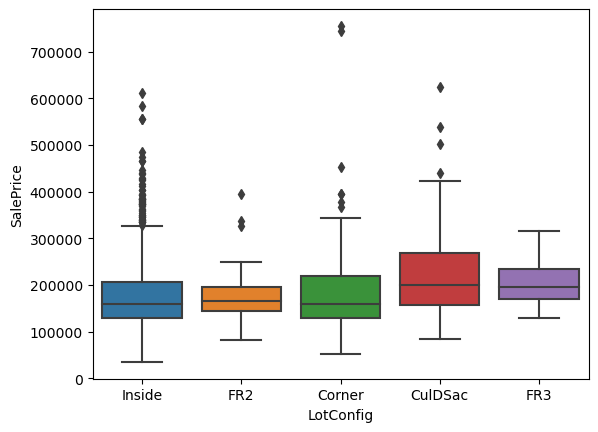

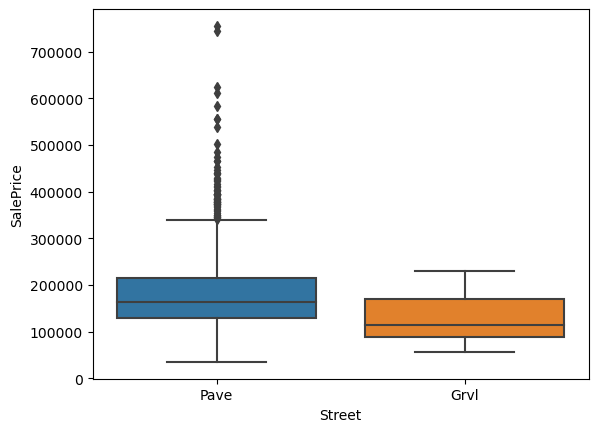

In [24]:
# EDA (Exploratory Data Analysis) of categorical cols (by using Boxplots) and
# choosing the columns with significant differences of the labels

for i in cat_cols:
    sns.boxplot(x=i, y="SalePrice", data=df)
    plt.show()

In [25]:
# implementing automatic Anova approach for treatment of the categorical columns
# defining a function to get the p_value
import scipy.stats as stats
def p_test_cat(dataframe,col_x,col_y):
    cols=list(dataframe[col_x].value_counts().index) 
    results=[]
    for i in cols:
        i=dataframe[dataframe[col_x]==i][[col_y]]
        results.append(i)
    statistics, p_value=stats.f_oneway(*results)
    return p_value

In [26]:
# selecting the columns to delete (with p_value > 0.05)
cols_to_drop=[]
for i in cat_cols:
    if p_test_cat(df,i,'SalePrice')>0.05:
        cols_to_drop.append(i)
cols_to_drop

['Utilities', 'LandSlope', 'Street']

In [27]:
# deleting the chosen columns
df=df.drop(cols_to_drop,axis=1)

In [29]:
# final check of nans for the categorical columns, all of them are cleaned
all_cols=list(df.columns)
num_cols=list(df._get_numeric_data().columns)
cat_cols=list(set(all_cols)-set(num_cols))
round(df[cat_cols].isna().sum()/len(df[cat_cols])*100,2)

RoofMatl         0.0
BsmtFinType1     0.0
PoolQC           0.0
Fence            0.0
GarageCond       0.0
Condition2       0.0
Functional       0.0
BldgType         0.0
MasVnrType       0.0
HouseStyle       0.0
RoofStyle        0.0
BsmtExposure     0.0
GarageType       0.0
ExterCond        0.0
MSZoning         0.0
ExterQual        0.0
LandContour      0.0
Exterior2nd      0.0
BsmtCond         0.0
Heating          0.0
KitchenQual      0.0
Condition1       0.0
HeatingQC        0.0
BsmtQual         0.0
GarageQual       0.0
Electrical       0.0
Alley            0.0
PavedDrive       0.0
BsmtFinType2     0.0
Foundation       0.0
Neighborhood     0.0
GarageFinish     0.0
FireplaceQu      0.0
CentralAir       0.0
LotShape         0.0
Exterior1st      0.0
MiscFeature      0.0
SaleType         0.0
SaleCondition    0.0
LotConfig        0.0
dtype: float64

In [31]:
# now I'll go on with the numerical columnss treatment of nans
round(df[num_cols].isna().sum()/len(df[num_cols])*100,2)

MSSubClass        0.00
LotFrontage      17.74
LotArea           0.00
OverallQual       0.00
OverallCond       0.00
YearBuilt         0.00
YearRemodAdd      0.00
MasVnrArea        0.55
BsmtFinSF1        0.00
BsmtFinSF2        0.00
BsmtUnfSF         0.00
TotalBsmtSF       0.00
1stFlrSF          0.00
2ndFlrSF          0.00
LowQualFinSF      0.00
GrLivArea         0.00
BsmtFullBath      0.00
BsmtHalfBath      0.00
FullBath          0.00
HalfBath          0.00
BedroomAbvGr      0.00
KitchenAbvGr      0.00
TotRmsAbvGrd      0.00
Fireplaces        0.00
GarageYrBlt       5.55
GarageCars        0.00
GarageArea        0.00
WoodDeckSF        0.00
OpenPorchSF       0.00
EnclosedPorch     0.00
3SsnPorch         0.00
ScreenPorch       0.00
PoolArea          0.00
MiscVal           0.00
MoSold            0.00
YrSold            0.00
SalePrice         0.00
dtype: float64

In [32]:
# replacing nans for the columns with nans by the medians
df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['GarageYrBlt']=df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

In [40]:
# building the correlation matrix for the numerical data to estimate correlations
corr=df[num_cols].corr()
corr

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.356718,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.081396,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.356718,1.000000,0.304522,0.234812,-0.053281,0.116685,0.083348,0.178469,0.214367,0.042463,0.124098,0.363472,0.413773,0.072388,0.037469,0.368007,0.090343,-0.006979,0.180534,0.047222,0.236840,-0.004905,0.320518,0.233221,0.062996,0.269539,0.323511,0.075542,0.137014,0.010287,0.061945,0.037655,0.180819,-0.000255,0.010451,0.006380,0.334771
LotArea,-0.139781,0.304522,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.025865,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.234812,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.514231,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.053281,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.306276,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.116685,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.777182,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.083348,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.616444,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.023573,0.178469,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,0.360067,0.339850,0.173800,-0.068628,0.388052,0.083010,0.027403,0.272999,0.199108,0.102775,-0.038450,0.279568,0.247015,0.244444,0.361945,0.370884,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
BsmtFinSF1,-0.069836,0.214367,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.148782,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.042463,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.087684,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


In [41]:
# selecting columns with weak correlation (threshold < 0.5) to be deleted
limit=0.5
corr_remove=corr[(corr["SalePrice"]<limit)& (corr["SalePrice"]>-limit)]
list_corr_remove=list(corr_remove.index)
list_corr_remove

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageYrBlt',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [42]:
# deleting the selected numerical columns
df=df.drop(list_corr_remove,axis=1)

In [24]:
# final check of the numerical columns, there are no nans
all_cols=list(df.columns)
num_cols=list(df._get_numeric_data().columns)
round(df[num_cols].isna().sum()/len(df[num_cols])*100,2)

LotFrontage     0.0
LotArea         0.0
OverallQual     0.0
YearBuilt       0.0
YearRemodAdd    0.0
MasVnrArea      0.0
BsmtFinSF1      0.0
TotalBsmtSF     0.0
1stFlrSF        0.0
2ndFlrSF        0.0
GrLivArea       0.0
FullBath        0.0
HalfBath        0.0
TotRmsAbvGrd    0.0
Fireplaces      0.0
GarageYrBlt     0.0
GarageCars      0.0
GarageArea      0.0
WoodDeckSF      0.0
OpenPorchSF     0.0
SalePrice       0.0
dtype: float64

In [43]:
# coding categorical columns into numerical
dfc=df.copy()
dfc[cat_cols].columns

Index(['RoofMatl', 'BsmtFinType1', 'PoolQC', 'Fence', 'GarageCond',
       'Condition2', 'Functional', 'BldgType', 'MasVnrType', 'HouseStyle',
       'RoofStyle', 'BsmtExposure', 'GarageType', 'ExterCond', 'MSZoning',
       'ExterQual', 'LandContour', 'Exterior2nd', 'BsmtCond', 'Heating',
       'KitchenQual', 'Condition1', 'HeatingQC', 'BsmtQual', 'GarageQual',
       'Electrical', 'Alley', 'PavedDrive', 'BsmtFinType2', 'Foundation',
       'Neighborhood', 'GarageFinish', 'FireplaceQu', 'CentralAir', 'LotShape',
       'Exterior1st', 'MiscFeature', 'SaleType', 'SaleCondition', 'LotConfig'],
      dtype='object')

In [44]:
# for encoding the columns I use the OrdinalEncoder 
# coding the columns, deleting the old ones and forming the final dataset
encoder= OrdinalEncoder()
data_transform=dfc[cat_cols]
oe_fit=encoder.fit(data_transform)
data_transform_df=pd.DataFrame(oe_fit.transform(data_transform))
data_transform_df.columns=cat_cols
dfc=dfc.drop(cat_cols,axis=1)
dfc=dfc.merge(data_transform_df, how='inner', left_index=True, right_index=True)

In [46]:
# final check of the dataset - non nans, datatypes are properly arranged for further modelling
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1460 non-null   int64  
 1   YearBuilt      1460 non-null   int64  
 2   YearRemodAdd   1460 non-null   int64  
 3   TotalBsmtSF    1460 non-null   int64  
 4   1stFlrSF       1460 non-null   int64  
 5   GrLivArea      1460 non-null   int64  
 6   FullBath       1460 non-null   int64  
 7   TotRmsAbvGrd   1460 non-null   int64  
 8   GarageCars     1460 non-null   int64  
 9   GarageArea     1460 non-null   int64  
 10  SalePrice      1460 non-null   int64  
 11  RoofMatl       1460 non-null   float64
 12  BsmtFinType1   1460 non-null   float64
 13  PoolQC         1460 non-null   float64
 14  Fence          1460 non-null   float64
 15  GarageCond     1460 non-null   float64
 16  Condition2     1460 non-null   float64
 17  Functional     1460 non-null   float64
 18  BldgType

In [47]:
# STAGE 2 - MODELLING
# before embarking on the modelling, I'm implementing perturbation of the dataset
dfr=pd.DataFrame(np.random.permutation(dfc.values),columns=dfc.columns)

In [48]:
# defining X and y
X=dfr.drop("SalePrice",axis=1)
y=dfr[["SalePrice"]]

In [49]:
# Outliers removal
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X)
mask = yhat != -1
X,y=X.loc[mask,:],y.loc[mask,:]

In [57]:
# splitting data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.02, random_state = 42)

In [50]:
# I'll start with RandomizedSearchCV example (faster) for Hyperparameter tuning of XGB
gbm = xgb.XGBRegressor()
gbm_param_grid_RG = {
    'colsample_bytree': [0.3, 0.7, 1.0],
    'n_estimators': [150,200,250,300],
    'max_depth': range(2, 11)}
randomized_mse_RG = RandomizedSearchCV(param_distributions=gbm_param_grid_RG, estimator=gbm, scoring="neg_mean_squared_error", n_iter=10, cv=5, verbose=1)
randomized_mse_RG.fit(X, y)
print("Best parameters found: ", randomized_mse_RG.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse_RG.best_score_)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'n_estimators': 300, 'max_depth': 2, 'colsample_bytree': 1.0}
Lowest RMSE found:  23660.3560348853


In [52]:
# fitting the model with the optimal parameters for the stage of predicting test dataset
xgb_params=randomized_mse_RG.best_params_
xgb_opt=xgb.XGBRegressor(**xgb_params)
xgb_opt.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [53]:
# Bayesian Optimization for Hyperparameter tuning of XGB regressor
# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 300, 50),
        'seed': 0
    }

In [54]:
# Defining objective function
def objective(space):
    rgr=xgb.XGBRegressor(objective='reg:squarederror',
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    rgr.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)

    pred = rgr.predict(X_test)

    rmse_score = np.sqrt(metrics.mean_squared_error(y_test, pred))
    print ("SCORE:", rmse_score)
    return {'loss': rmse_score, 'status': STATUS_OK }

In [58]:
# running the algorythm for selecting the best hyperparameters
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
27544.0375470712                                       
SCORE:                                                                         
41098.134436635904                                                             
SCORE:                                                                         
31596.371853740708                                                             
SCORE:                                                                         
31711.648578102242                                                             
SCORE:                                                                         
30558.344622448454                                                             
SCORE:                                                                         
36493.79177756693                                                              
SCORE:                                                                         
33097.02

26688.363286755055                                                               
100%|██████████| 100/100 [00:23<00:00,  4.28trial/s, best loss: 25673.00759022546]


In [59]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5128911662154029, 'gamma': 8.57996616996855, 'max_depth': 8.0, 'min_child_weight': 9.0, 'n_estimators': 300.0, 'reg_alpha': 90.0, 'reg_lambda': 0.6855478723339279}


In [60]:
# retrieving the best parameters
best_params_hp={'colsample_bytree': 0.603484387927779, 'gamma': 2.537842343970997, 'max_depth': 6, 'min_child_weight': 9.0, 'n_estimators': 300, 'reg_alpha': 40.0, 'reg_lambda': 0.4538196703748296}

In [61]:
# fitting the model with the best parameters and calculating the score for the test data
xgb_opt=xgb.XGBRegressor(**best_params_hp)
xgb_opt.fit(X_train, np.ravel(y_train.values)) 
predictions=xgb_opt.predict(X_test.values)
rmse=np.sqrt(metrics.mean_squared_error(y_test,predictions))
rmse

30286.817241013516

In [62]:
# And finally I'll implement another algorythm of the ensemble trees 
# GradientBoostingRegressor
from scipy.stats import loguniform
n_estimators = [5,20,50,100,150,200,300] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
max_leaf_nodes=[2, 5, 10, 20, 50, 100]

random_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'max_leaf_nodes':max_leaf_nodes,
'learning_rate': loguniform(0.01, 1)}

print ('Random grid: ', random_grid, '\n')

Random grid:  {'n_estimators': [5, 20, 50, 100, 150, 200, 300], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'max_leaf_nodes': [2, 5, 10, 20, 50, 100], 'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002233737D6C0>} 



In [63]:
# initializing the model and running the GBR
# RMSE score is very close to that of XGBR
gbr=GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator = gbr,param_distributions = random_grid,
               n_iter = 100, cv = 3, verbose=2, random_state=35, n_jobs = -1, scoring="neg_mean_squared_error")
gbr_random.fit(X, y)
print("Best parameters found: ", gbr_random.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(gbr_random.best_score_)))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\test\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters found:  {'learning_rate': 0.08243466861912178, 'max_depth': 80, 'max_leaf_nodes': 5, 'n_estimators': 150}
Lowest RMSE found:  23680.96131022201


In [64]:
# fitting the model with the optimal parameters for the stage of predicting test dataset
gbr_opt_params=gbr_random.best_params_
gbr_opt = GradientBoostingRegressor(**gbr_opt_params)
gbr_opt.fit(X,np.ravel(y))

GradientBoostingRegressor(learning_rate=0.08243466861912178, max_depth=80,
                          max_leaf_nodes=5, n_estimators=150)

In [ ]:
# the both models GBR and XGBR showed good scores, all of them can be implemented for predicting the test dataset